<a href="https://colab.research.google.com/github/LucasDVirtuoso/LucasDVirtuoso/blob/main/monografia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CURRENT STANDARDS IN INTERNATIONAL TRADE: CHARACTERIZATION AND ANALYSIS OF THE EFFECT OF THE GLOBALGAP STANDARD ON FRUIT EXPORTS IN BRAZIL, CHILE, AND ARGENTINA.**

** Lucas Duarte Virtuoso

** Talles Girardi de Mendonça

---

**THIS WORK WAS INITIALLY CARRIED OUT AS AN ACADEMIC RESEARCH PROJECT AT THE FEDERAL UNIVERSITY OF SÃO JOÃO DEL-REI (UFSJ). LATER, MY ADVISOR AND I EXPANDED THE WORK AND REFINED IMPORTANT POINTS, FINALLY TRANSFORMING IT INTO MY MONOGRAPH PROJECT TO OBTAIN THE DEGREE OF BACHELOR IN ECONOMICS.**

FOR MORE INFORMATION AND DETAILS ABOUT THE RESEARCH AND RESULTS, CONSIDER EVALUATING THE COMPLETE WORK, AVAILABLE IN THE GITHUB REPOSITORY, AND IN THE OFFICIAL UFSJ MONOGRAPH DATABASE.

---

**The main objective is to study the effect of the GlobalGAP standard on the export levels of fruits by Brazilian state. For this task, we'll use an regression OLS model with panel data that controls for fixed effects over time and across states.**

## FIRST STEP: IMPORTING LIBRARIES AND CONNECTING TO GOOGLE DRIVE.

In [ ]:
pip install linearmodels #to deal with panel data

In [35]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For statistic and econometrics
import statsmodels.api as sm #OLS
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd # heteroskedasticity test
from statsmodels.stats.outliers_influence import variance_inflation_factor # multicollinearity

from linearmodels import PooledOLS
from linearmodels import PanelOLS # most important!
from linearmodels import RandomEffects

# Plot maps
import geopandas as gpd
import matplotlib.pyplot as plt

from scipy import stats #zscore!


In [9]:
# Connect the notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now everything is set up to start! The database is in my google drive, which is why I'm connecting them -- it's easier!

## SECOND STEP: DATA CLEANING AND TREANTMENT

Looking at the database, I found some inconsistencies, so I will treat them before proceeding with the analysis.

---


Some decisions about the data were made arbitrarily based on the researcher's judgment to best fit the research objectives.

In [10]:
path = '/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/BASE_BRASIL.xlsx'

In [11]:
# Get the data
br = pd.read_excel(path, sheet_name=0)
br.head() # first look, btw the df is named 'br' for Brazil (first two letters, in case of doubt)

,ano,estado,regiao,fruta,exp_kg,exp_fob,exp_USD/KG,empresas_gg,area_plantada(ha),area_colhida(ha),qte_produzida(ton),rendimento_medio_producao(kg/ha),valor_producao(mil reais),rendimento_medio_producao(R$/Kg),renda_internacional,renda_int_bilh
0,2018,alagoas,Nordeste,abacate,5,14,2.800000,NaN,101,101,980,9703,1809,1.845918,2.120494e+11,212.049447
1,2018,alagoas,Nordeste,limao_e_lima,63,140,2.222222,NaN,322,322,1909,5929,3594,1.882661,2.120494e+11,212.049447
2,2018,alagoas,Nordeste,maca,766,2071,2.703655,NaN,0,0,0,0,0,0.000000,3.251213e+11,325.121254
3,2018,alagoas,Nordeste,manga,345,477,1.382609,NaN,1301,1301,11201,8610,8275,0.738773,9.981976e+11,998.197567
4,2018,alagoas,Nordeste,melancia,384,186,0.484375,NaN,960,960,17919,18666,14992,0.836654,2.120494e+11,212.049447


In [12]:
# Check data information
br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ano                               693 non-null    int64  
 1   estado                            693 non-null    object 
 2   regiao                            693 non-null    object 
 3   fruta                             693 non-null    object 
 4   exp_kg                            693 non-null    int64  
 5   exp_fob                           693 non-null    int64  
 6   exp_USD/KG                        693 non-null    float64
 7   empresas_gg                       143 non-null    float64
 8   area_plantada(ha)                 693 non-null    int64  
 9   area_colhida(ha)                  693 non-null    int64  
 10  qte_produzida(ton)                693 non-null    int64  
 11  rendimento_medio_producao(kg/ha)  693 non-null    int64  
 12  valor_pr

To get an deeper understanding about the definition and meaning of each variable, check the archieve named 'readme'

---

*'empresas_gg' is the most important variable, it correspond to the number of globalgap standards for a given fruit in a given state in a given year of the analysis.*


*'exp_fob** is the value exported by a given state in a given year measured in free on board (FOB) american dollars.*

**About the next proceedures:**

- The Null values in 'empresas_gg' is because some states for some fruits don't have any gg standard for the fruit in the year observerd, so I'll fill them with zero.

- 'empresas_gg' is in float format, but it makes no sense once the standard can't be in a decimal number. So I'll also convert it to integer type (int)

- Rename columns is going to be important to make the dataset easier to deal with

*For now lets apply this changes and get a new viwe about the data*

In [13]:
# Look at some identified problemns
br.isnull().sum().sum()

550

In [14]:
br.isnull().sum() # distribution of null values

,0
ano,0
estado,0
regiao,0
fruta,0
exp_kg,0
exp_fob,0
exp_USD/KG,0
empresas_gg,550
area_plantada(ha),0
area_colhida(ha),0


Only on columns has nulls but, I'll fill them with zeros (previously explained why)

In [15]:
# Check for repeated entries
# even though I already knew it hasn't duplicates by the form data was collected it's always good to check.
br.duplicated().sum()

0

In [16]:
br['empresas_gg'].fillna(0, inplace=True) # fill null with zeros
br['empresas_gg'] = br['empresas_gg'].astype(int) # convert to integer

# rename columns
br.rename(columns={'exp_USD/KG': 'preco',
                   'qte_produzida(ton)': 'producao',
                   'renda_int_bilh': 'renda'},
          inplace=True)

<ipython-input-16-f83f58f4a20b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br['empresas_gg'].fillna(0, inplace=True) # fill null with zeros


Now let's check our data again
- Descriptive statistics on the variable

- Some charts to found inconsistences and see them better

In [17]:
br.describe().T

,count,mean,std,min,25%,50%,75%,max
ano,693.0,2.020056e+03,1.389892e+00,2.018000e+03,2.019000e+03,2.020000e+03,2.021000e+03,2.022000e+03
exp_kg,693.0,6.170503e+06,2.136184e+07,5.000000e+00,3.443000e+03,3.493600e+04,9.349320e+05,1.867893e+08
exp_fob,693.0,5.457896e+06,1.798343e+07,5.000000e+00,4.742000e+03,3.790300e+04,6.196810e+05,1.231581e+08
preco,693.0,1.437002e+00,1.066714e+00,2.576256e-02,7.265556e-01,1.156366e+00,1.831000e+00,7.131367e+00
empresas_gg,693.0,3.002886e+00,1.302277e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.460000e+02
area_plantada(ha),693.0,2.741915e+03,6.219549e+03,0.000000e+00,8.000000e+00,3.420000e+02,2.067000e+03,4.685800e+04
area_colhida(ha),693.0,2.724296e+03,6.195711e+03,0.000000e+00,8.000000e+00,3.420000e+02,2.052000e+03,4.685700e+04
producao,693.0,6.815312e+04,1.611866e+05,0.000000e+00,8.600000e+01,4.495000e+03,5.006100e+04,1.199368e+06
rendimento_medio_producao(kg/ha),693.0,1.525417e+04,1.293315e+04,0.000000e+00,5.036000e+03,1.451100e+04,2.254600e+04,7.380600e+04
valor_producao(mil reais),693.0,9.176114e+04,2.319472e+05,0.000000e+00,1.070000e+02,7.481000e+03,6.327700e+04,1.712957e+06


Looking at this data we can see that it has a very asymetric distribution in most columns. This can interfeer the model estimation, so I'll standardize some variables, and their dimensions.

Most variables are measured in kilogramns, so variables in tons will be converted to KG

In [18]:
br['producao'] = br['producao']*1000 # convert to kg

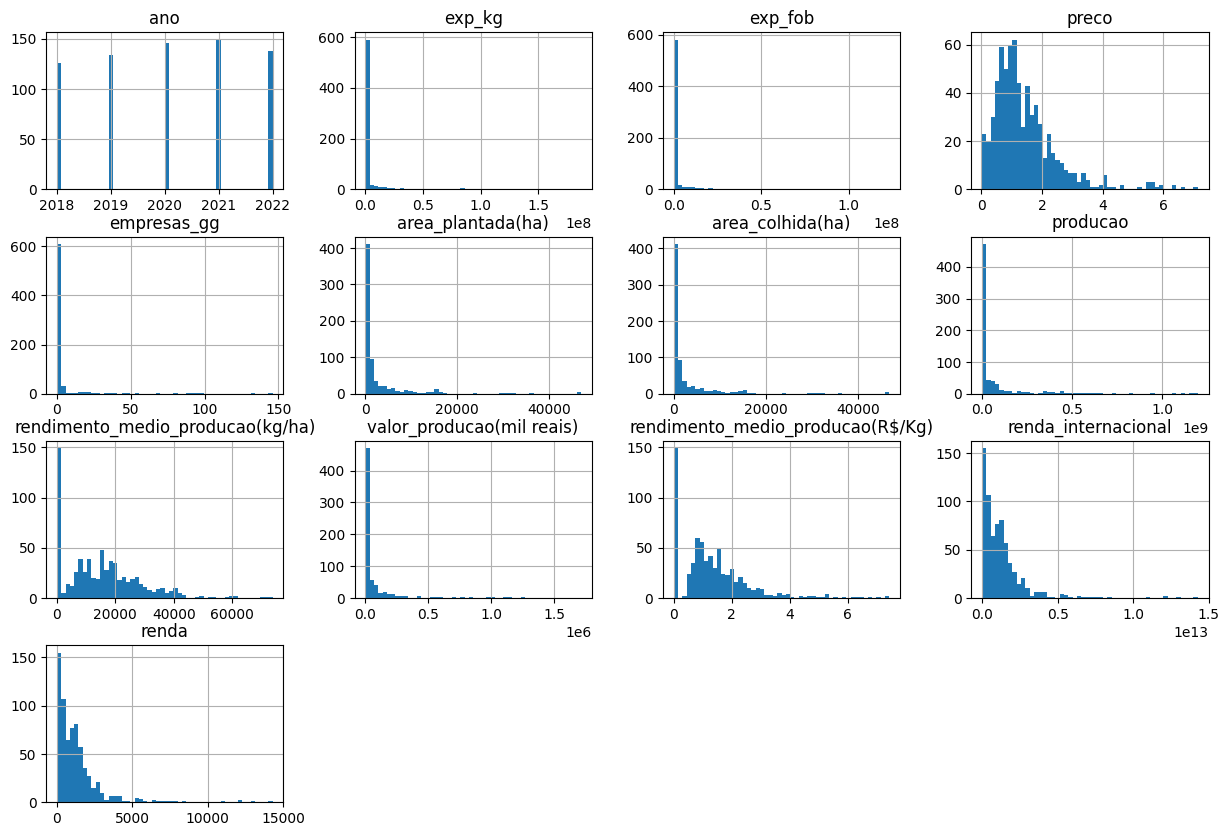

In [19]:
# Show the distribution of variables
br.hist(figsize=(15,10), bins=50)
plt.show() # make the output cleaner

* **All quantitative variables are highly distorted. This is, of course, due to the nature of the data we are dealing with. These are expected results given the asymmetric conditions of the data, but these distributions can make analysis difficult and influence econometric modeling.**


* **I will transform the main variables of the model into logarithms. This way they will be on a comparable scale and can help correct heteroskedasticity problems when modeling.**

* **Some values ​​do not meet the mathematical conditions for logarithmization, so when applying logarithms to them, their values ​​tend to a minus infinity limit. These "minus infinities" are values ​​that will create problems for us later on, so we must deal with them. I HAVE CHOSE TO REPLACE THEM WITH ZERO, because they come from the logarithm applied to zeros, as such a result does not exist in the set of numbers we are working with, I have chosen to keep zero to avoid losing observations.**

In [20]:
# Transform variables into logs
br['exp_fob'] = np.log(br['exp_fob'])
br['preco'] = np.log(br['preco'])
br['producao'] = np.log(br['producao'])
br['renda'] = np.log(br['renda'])
br['renda_internacional'] = np.log(br['renda_internacional'])

br.replace(-np.inf, 0, inplace=True) # replace -inf with zero

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
# Looking at the data again, now with log variables
br.describe().T

,count,mean,std,min,25%,50%,75%,max
ano,693.0,2.020056e+03,1.389892e+00,2018.000000,2019.000000,2020.000000,2021.000000,2.022000e+03
exp_kg,693.0,6.170503e+06,2.136184e+07,5.000000,3443.000000,34936.000000,934932.000000,1.867893e+08
exp_fob,693.0,1.103766e+01,3.481909e+00,1.609438,8.464214,10.542786,13.336960,1.862898e+01
preco,693.0,8.797021e-02,8.259318e-01,-3.658833,-0.319440,0.145282,0.604862,1.964503e+00
empresas_gg,693.0,3.002886e+00,1.302277e+01,0.000000,0.000000,0.000000,0.000000,1.460000e+02
area_plantada(ha),693.0,2.741915e+03,6.219549e+03,0.000000,8.000000,342.000000,2067.000000,4.685800e+04
area_colhida(ha),693.0,2.724296e+03,6.195711e+03,0.000000,8.000000,342.000000,2052.000000,4.685700e+04
producao,693.0,1.265653e+01,7.021691e+00,0.000000,11.362103,15.318476,17.728753,2.090506e+01
rendimento_medio_producao(kg/ha),693.0,1.525417e+04,1.293315e+04,0.000000,5036.000000,14511.000000,22546.000000,7.380600e+04
valor_producao(mil reais),693.0,9.176114e+04,2.319472e+05,0.000000,107.000000,7481.000000,63277.000000,1.712957e+06


**There still appears to be large dispersions in the distribution of the data although such dispersion has been reduced.**

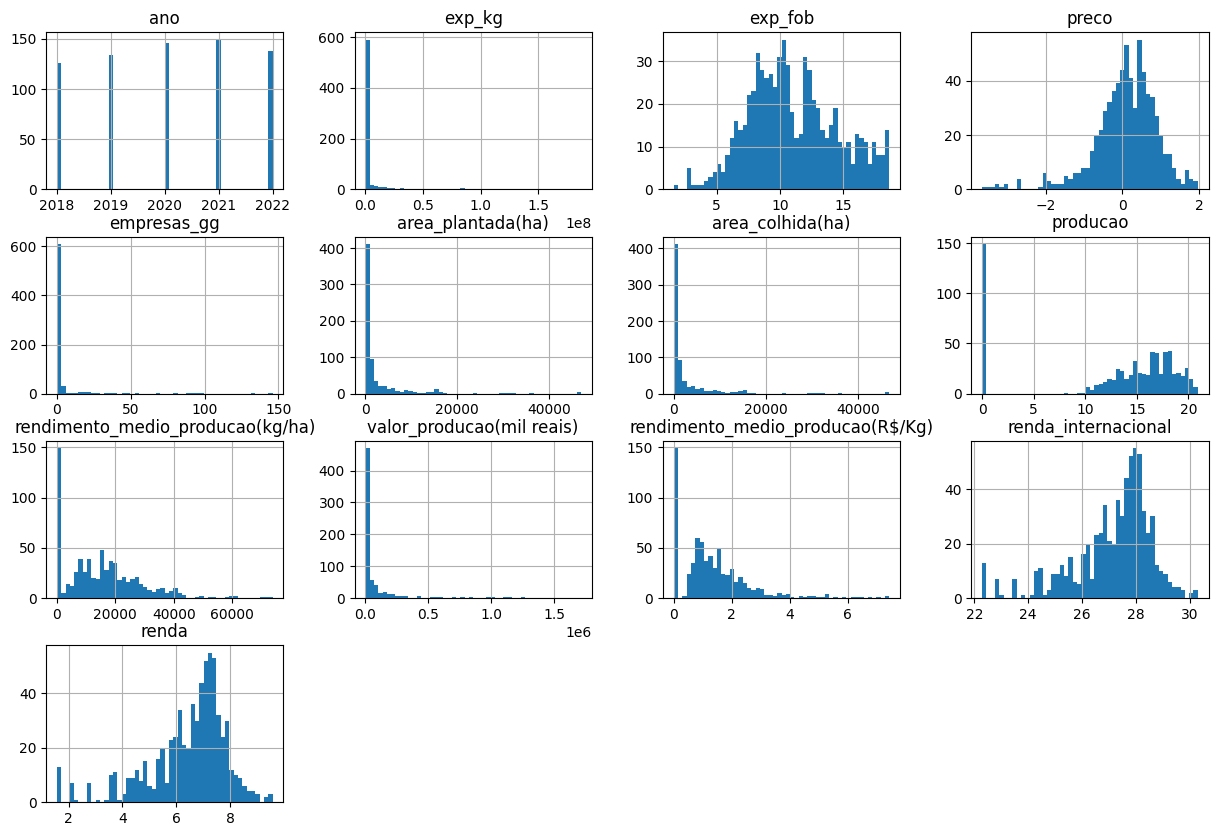

In [22]:
br.hist(figsize=(15,10), bins=50)
plt.show() # make the output cleaner

**The logarithmized variables presented a distribution closer to normal, but still with some distortion. I will proceed to see to what extent the data as it is will be effective for the research problem.**

In [23]:
br.shape

(693, 16)

**Finally, I will create the dummy variables that will be used in the models. These models will use the states, fruits, and time ('year').**

**To insert the intercept in the model as is customary in econometrics, we must exclude one of the dummies with the argument 'drop_first='**

**I made dummies only for fruits because the index is going to be redifined with the others dummy varibales for control panel fixed effects.**

In [24]:
br2 = pd.get_dummies(br, columns=['fruta'], drop_first=True, dtype=int) # dtype to avoid bool values in dummies

In [25]:
# Set panel index
br2.set_index(['estado', 'ano'], inplace=True)
br2.head()

regiao  exp_kg   exp_fob     preco  empresas_gg  \
estado  ano                                                       
alagoas 2018  Nordeste       5  2.639057  1.029619            0   
        2018  Nordeste      63  4.941642  0.798508            0   
        2018  Nordeste     766  7.635787  0.994605            0   
        2018  Nordeste     345  6.167516  0.323972            0   
        2018  Nordeste     384  5.225747 -0.724896            0   

              area_plantada(ha)  area_colhida(ha)   producao  \
estado  ano                                                    
alagoas 2018                101               101  13.795308   
        2018                322               322  14.462090   
        2018                  0                 0   0.000000   
        2018               1301              1301  16.231514   
        2018                960               960  16.701372   

              rendimento_medio_producao(kg/ha)  valor_producao(mil reais)  \
estado  ano                                                                 
alagoas 2018                              9703                       1809   
        2018                              5929                       3594   
        2018                                 0                          0   
        2018                              8610                       8275   
        2018                             18666                      14992   

              rendimento_medio_producao(R$/Kg)  renda_internacional     renda  \
estado  ano                                                                     
alagoas 2018                          1.845918            26.080085  5.356819   
        2018                          1.882661            26.080085  5.356819   
        2018                          0.000000            26.507464  5.784198   
        2018                          0.738773            27.629217  6.905951   
        2018                          0.836654            26.080085  5.356819   

              fruta_limao_e_lima  fruta_maca  fruta_mamao  fruta_manga  \
estado  ano                                                              
alagoas 2018                   0           0            0            0   
        2018                   1           0            0            0   
        2018                   0           1            0            0   
        2018                   0           0            0            1   
        2018                   0           0            0            0   

              fruta_melancia  fruta_melao  fruta_uva  
estado  ano                                           
alagoas 2018               0            0          0  
        2018               0            0          0  
        2018               0            0          0  
        2018               0            0          0  
        2018               1            0          0

## THIRD STEP: ECONOMETRICS

**Now I'm going to create the variables that will make the model below that we estimate based on the theory analyzed to measure the impact of the standard on exports.**

$$
\ln(x_{it}) = \beta_0 + \beta_1 (\text{empresas}_{it}) + \beta_2 \ln(\text{preço}_{it}) + \beta_3 \ln(\text{produção}_{it}) + \beta_4 \ln(\text{renda}_{it}) + \sum_{e=1}^{n-1} c_e D_{ei} + \sum_{t=2018}^{2022} c_t D_{tt} + \sum_{f=1}^{8} \gamma_f D_{fi} + \varepsilon_{it}
$$


In [26]:
# Set the variables

X = br2.drop(columns=['exp_fob', 'regiao', 'renda_internacional', 'area_plantada(ha)',
                              'area_colhida(ha)', 'rendimento_medio_producao(kg/ha)',
                              'valor_producao(mil reais)', 'rendimento_medio_producao(R$/Kg)',
                              'exp_kg'], axis=1) # remove unnecessary columns

Y = br2['exp_fob'] # target variable

X = sm.add_constant(X) # add intercept to the model


---
**FIXED EFFECT**
  - Two-way panel regression for years and state

In [27]:
fe = PanelOLS(Y, X, entity_effects=True, time_effects=True) # model architecture
fe = fe.fit() # model estimation
print(fe.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                exp_fob   R-squared:                        0.3279
Estimator:                   PanelOLS   R-squared (Between):              0.5864
No. Observations:                 693   R-squared (Within):               0.3242
Date:                Wed, Jan 22 2025   R-squared (Overall):              0.4489
Time:                        19:55:01   Log-likelihood                   -1471.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      29.046
Entities:                          23   P-value                           0.0000
Avg Obs:                       30.130   Distribution:                  F(11,655)
Min Obs:                       1.0000                                           
Max Obs:                       40.000   F-statistic (robust):             29.046
                            

**Check the regression model assumptions regarding variance: heteroscedasticity**

In [28]:
residuals = fe.resids # get resids from the model
wt = smd.het_white(resid=residuals, exog=X) # performs the White test for the panel model
print('lm:', wt[0], '\nlm_pvalue:', wt[1]) # returns the Lagrange Multiplier coefficients and their p-value

lm: 63.216251838833344 
lm_pvalue: 0.06939445657528619


**With these results we can see that:**
- The variable that interests us most in the inference is the number of certified companies. Analyzing these values, we can see that at a confidence level of 5%, the variable was significant by the p-value hypothesis test. In addition to being significant, the effect was significant, with an additional certification increasing exports by 5.6% on average, keeping the other variables constant.

- The analysis of the other variables and their interpretations in the model according to the bibliography used for research can be found in the final version of the article, which can be found in the GitHub repository or in the publication itself.

- We can observe the low R² value that the model presented, 32.42%. Therefore, it must be considered that the regression does not fit very well. Around 32.49% of the variations in exports are explained by the variables inserted in the model, a low percentage.

- Finally, regarding heteroscedasticity, the White test was performed. This was chosen because it is considered more robust in relation to different error distributions, considering that we are dealing with a model in which the form of heteroscedasticity is unknown (Lyon and Tsai, 1996). The White test indicated the acceptance of the null hypothesis, which indicates that the residuals are homoscedastic.

**In conclusion, adherence to the GLOBALGAP standard in its analyzed standard (IFA FV) is a variable that has significant effects on the expansion of exports in the Brazilian case of the analyzed fruits.**

## FOURTH STEP: MODEL WITH STANDARDIZED VARIABLES

---
The Z-score, also known as the standard score, is a statistical measurement that describes a value's relationship to the mean of a group of values. It is expressed as the number of standard deviations a data point (X) is away from the mean (
𝜇
μ). The primary objective of standardizing variables using the Z-score is to bring all variables to a common scale, enabling comparisons between them, even if the original variables had different units or scales. This is particularly useful when variables with different units (e.g. Weight in kilograms) may need to be treated equally. By standardizing, you ensure that each variable contributes equally to the model or analysis, regardless of its original scale.

**This also allows an analysis of the impact dimension of each variable in the model.**


$$ Z = \frac{X - \mu}{\sigma} $$


- X: This represents the raw score or value of the observation that we are standardizing. It is the individual data point whose position relative to the mean we are interested in.
𝜇

- μ (Population Mean): This is the mean (average) of the entire population of data points. It represents the central tendency or the "average" value of the dataset.
𝜎

- σ (Population Standard Deviation): This is the standard deviation of the entire population of data points. It measures the spread or dispersion of the data from the mean, showing how much variability exists in the data.

- Z: This is the resulting Z-score, which tells us how many standard deviations the data point
𝑋
X is from the population mean
𝜇
μ. If the Z-score is positive,
𝑋
X is above the mean, and if it is negative,
𝑋
X is below the mean.


In [29]:
# We only standardizing variables that aren't dummies
continuos_var = ['preco', 'empresas_gg', 'producao', 'renda'] # continuous variables list
dummies_var = ['fruta_limao_e_lima', 'fruta_maca', 'fruta_mamao', 'fruta_manga', 'fruta_melancia', 'fruta_melao', 'fruta_uva'] # dummy variables list

# Separate continuous and dummy variables
z_cont = X[continuos_var]
z_dummies = X[dummies_var]

# Standardize variables
zX = z_cont.apply(stats.zscore)
zY = stats.zscore(Y)

zX = sm.add_constant(zX) # add intercept to the model
zX = pd.concat([zX, z_dummies], axis=1) # unites DataFrames

In [30]:
# Check for null values again ...
zeros_X = zX.isnull().sum().sum()
zeros_Y = zY.isnull().sum().sum()
print(zeros_X, zeros_Y)

0 0


In [31]:
# Fixed Effects for standardizing variables
fe_z = PanelOLS(zY, zX, entity_effects=True, time_effects=True)
fe_z = fe_z.fit()
print(fe_z.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                exp_fob   R-squared:                        0.3279
Estimator:                   PanelOLS   R-squared (Between):              0.5864
No. Observations:                 693   R-squared (Within):               0.3242
Date:                Wed, Jan 22 2025   R-squared (Overall):              0.4489
Time:                        19:55:01   Log-likelihood                   -607.30
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      29.046
Entities:                          23   P-value                           0.0000
Avg Obs:                       30.130   Distribution:                  F(11,655)
Min Obs:                       1.0000                                           
Max Obs:                       40.000   F-statistic (robust):             29.046
                            

When we standardize a variable, we transform its values ​​into standard deviations from the mean. One unit in the standardized independent variables represents one standard deviation from its original mean. The estimated coefficient for a standardized variable indicates the change in the standardized dependent variable (also measured in standard deviations) associated with a change of 1 standard deviation in the independent variable.



In the model with standardized variables, the most relevant variable will be the one whose standardized coefficient has the greatest magnitude (absolute value).

This is because:

- *In a standardized model, the coefficients are directly comparable to each other, since all variables are on the same scale.*

- *The magnitude reflects the proportional impact of each variable on the dependent variable.*



**The coefficient with the highest absolute value indicates the variable with the greatest relative relevance in explaining exports. In this case, we can see that the variable 'income', which represents the income of importing countries weighted by their GDP, has a greater impact in explaining the variable of exports of Brazilian fruits than the other variables. In second place comes our study variable, adherence to GlobalGap, which shows us that although it is relevant and impacts exports, it is not the main defining factor of the process. International demand for products has a greater effect in explaining the level of exports than adherence to the standard, although adherence to the standard does have a considerable impact on the target variable.**

---

## FIFTH STEP*: DATA VISUALIZATION (CHARTS)

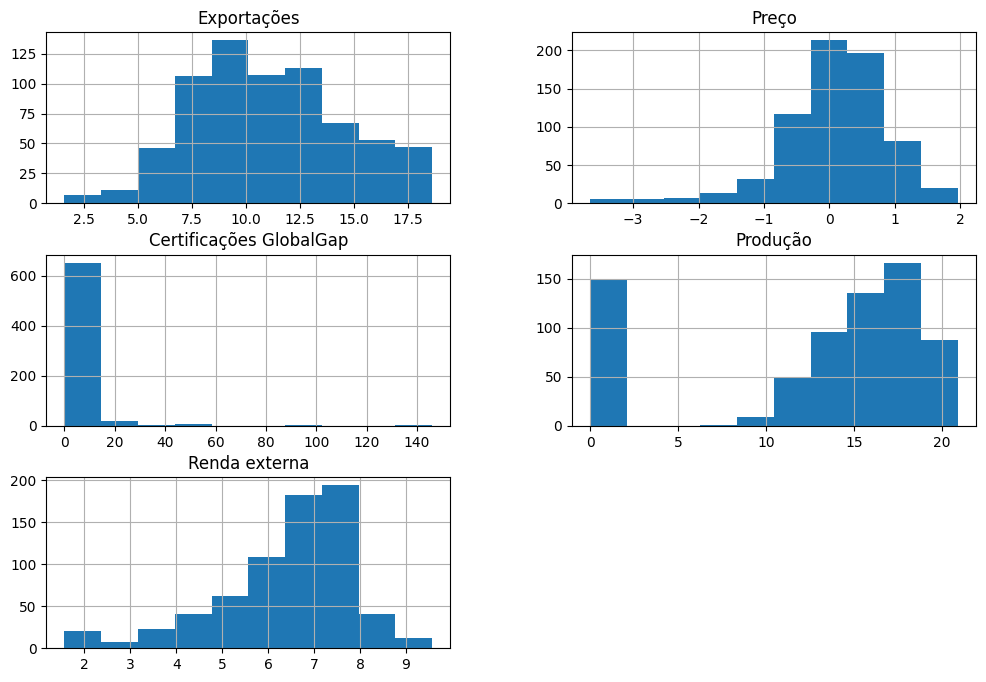

In [32]:
# New DataFrame
br3 = br.copy()
br3 = br3[['exp_fob', 'preco', 'empresas_gg', 'producao', 'renda']]

# Rename columns for the article
br3.columns = ['Exportações', 'Preço', 'Certificações GlobalGap', 'Produção', 'Renda externa']

br3.hist(figsize=(12,8))
plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


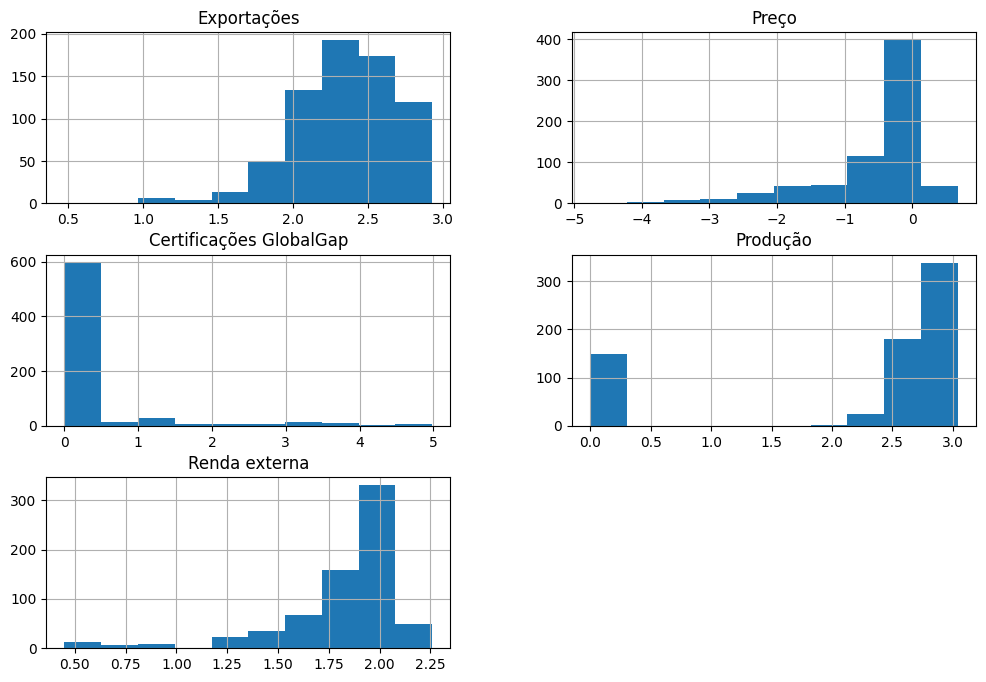

In [33]:
# New DataFrame log variables
br4 = br.copy()
br4 = br4[['exp_fob', 'preco', 'empresas_gg', 'producao', 'renda']]
br4 = np.log(br4)
br4.replace(-np.inf, 0, inplace=True)
br4.replace(np.nan, 0, inplace=True)

# Rename columns for the article
br4.columns = ['Exportações', 'Preço', 'Certificações GlobalGap', 'Produção', 'Renda externa']

br4.hist(figsize=(12,8))
plt.show()

In [34]:
br4.head()

,Exportações,Preço,Certificações GlobalGap,Produção,Renda externa
0,0.970422,0.029189,0.0,2.624329,1.678370
1,1.597698,-0.225011,0.0,2.671531,1.678370
2,2.032846,-0.005410,0.0,0.000000,1.755130
3,1.819296,-1.127098,0.0,2.786955,1.932384
4,1.653598,0.000000,0.0,2.815491,1.678370


---

**DISPLAYS THE CHLOROPLETIC MAPS OF EACH COUNTRY, THE MAPS DISPLAY THE CUMULATIVE NUMBER OF GLOBALGAP CERTIFICATIONS BY PROVINCIES, STATES AND REGIONS OF EACH COUNTRY RESPECTIVELY IN THE PERIOD FROM 2018 TO 2022.**

In [37]:
### UPLOAD THE DATA ###
# SHAPEFILES for each country
path_argentina = '/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/Shapefiles/ARGENTINA/provincia.shp'
path_brasil = '/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/Shapefiles/BRASIL/BR_UF_2022.shp'
path_chile = '/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/Shapefiles/CHILE/Regional.shp'

# GLOBALGAP Certificates for each country in state level
uf_ar = pd.read_excel('/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/Shapefiles/combinar_shp.xlsx',
                      sheet_name=0)
uf_br = pd.read_excel('/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/Shapefiles/combinar_shp.xlsx',
                      sheet_name=1)
uf_ch = pd.read_excel('/content/drive/MyDrive/PROJETOS DS/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/Shapefiles/combinar_shp.xlsx',
                      sheet_name=2)

In [38]:
# Load shapefiles of Brazilian states, Argentine provinces and Chilean regions
ar_uf_d = gpd.read_file(path_argentina)
br_uf_d = gpd.read_file(path_brasil)
ch_uf_d = gpd.read_file(path_chile)


In [39]:
# Deletes unnecessary columns
br_uf_d.drop(columns=['CD_UF', 'SIGLA_UF', 'NM_REGIAO', 'AREA_KM2'], axis=1, inplace=True)
ar_uf_d.drop(columns=['gid', 'entidad', 'fna', 'gna', 'in1', 'fdc', 'sag'], axis=1, inplace=True)
ch_uf_d.drop(columns=['objectid', 'cir_sena', 'codregion', 'area_km', 'st_area_sh', 'st_length_'], axis=1, inplace=True)

In [40]:
# Renames the columns so that the names of the federative units are compatible
ar_uf_d.rename(columns={'nam': 'provincias'}, inplace=True)
br_uf_d.rename(columns={'NM_UF': 'estado'}, inplace=True)
ch_uf_d.rename(columns={'Region': 'regiones'}, inplace=True)

In [41]:
# Combines data based on the common column they have
geo_ar = pd.merge(uf_ar, ar_uf_d, on='provincias')
geo_br = pd.merge(uf_br, br_uf_d, on='estado')
geo_ch = pd.merge(uf_ch, ch_uf_d, on='regiones')


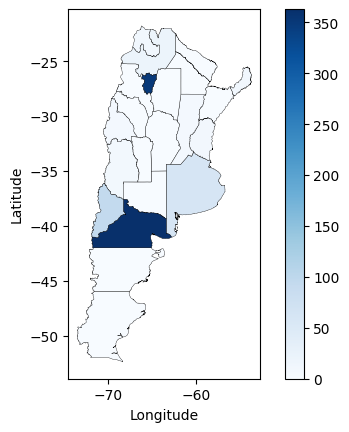

In [42]:
# Displays the chloroplectic map for Argentina
figsize=(18, 6)

gdf_ar = gpd.GeoDataFrame(geo_ar, geometry='geometry')
gdf_ar.plot(column='empresas_gg', cmap='Blues', edgecolor='black', linewidth=0.25, legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

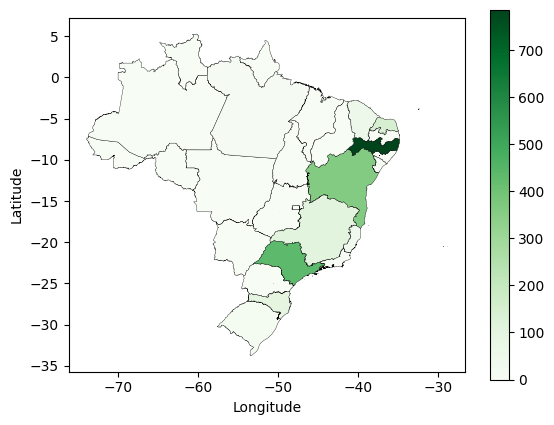

In [43]:
# Displays the chloroplectic map for Brazil
figsize=(18, 6)

gdf_br = gpd.GeoDataFrame(geo_br, geometry='geometry')
gdf_br.plot(column='empresas_gg', cmap='Greens', edgecolor='black', linewidth=0.25, legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

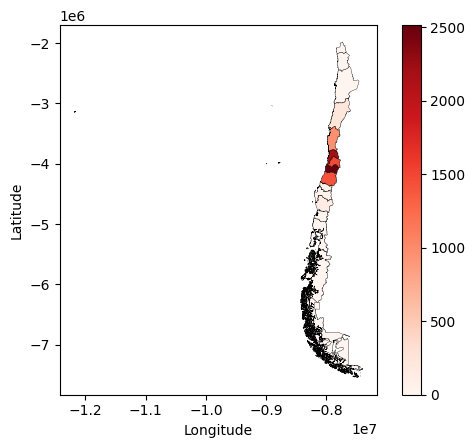

In [44]:
# Displays the chloroplectic map for Chile
figsize=(18, 6)

gdf_ch = gpd.GeoDataFrame(geo_ch, geometry='geometry')
gdf_ch.plot(column='empresas_gg', cmap='Reds', edgecolor='black', linewidth=0.25, legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

---